
Notebook criado para identifica√ß√£o de atributos em candidatos de sucesso.
Este caderno realiza:
- Carregamento e EDA
- Pr√©-processamento com pipeline
- Clusteriza√ß√£o com KMeans
- Redu√ß√£o de dimensionalidade para visualiza√ß√£o
- Exporta√ß√£o de fun√ß√µes e modelos para integra√ß√£o com Streamlit

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer # Importe SimpleImputer
import joblib
import os
import json
import warnings

warnings.filterwarnings('ignore')

In [22]:
def load_json_data(path):
    """
    Carrega dados de um arquivo JSON.

    Args:
        path (str): O caminho do arquivo JSON.

    Returns:
        dict: O conte√∫do do JSON carregado.
    """
    if not os.path.exists(path):
        print(f"Erro: O arquivo '{path}' n√£o foi encontrado.")
        return None
    try:
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Arquivo '{path}' carregado com sucesso.")
        return data
    except json.JSONDecodeError as e:
        print(f"Erro ao decodificar JSON do arquivo '{path}': {e}")
        return None
    except Exception as e:
        print(f"Erro ao carregar o arquivo '{path}': {e}")
        return None

vagas_data = load_json_data('vagas.json')
prospects_data = load_json_data('prospects.json')
applicants_data = load_json_data('applicants.json')

# Combine all data into a single dataset
combined_data = {
    "jobs": vagas_data,
    "prospects": prospects_data,
    "applicants": applicants_data
}

Arquivo 'vagas.json' carregado com sucesso.
Arquivo 'prospects.json' carregado com sucesso.
Arquivo 'applicants.json' carregado com sucesso.


In [23]:
def combine_dataframes(jobs_data, prospects_data, applicants_data):
    import pandas as pd

    if not all([jobs_data, prospects_data, applicants_data]):
        print("Erro: Um ou mais dicion√°rios de dados est√£o vazios ou n√£o foram carregados.")
        return pd.DataFrame()

    all_records = []

    for job_id, job_info in jobs_data.items():
        try:
            informacoes_basicas = job_info.get('informacoes_basicas', {})
            perfil_vaga = job_info.get('perfil_vaga', {})

            job_record = {
                'job_id': job_id,
                'is_sap_job': informacoes_basicas.get('vaga_sap'),
                'client': informacoes_basicas.get('cliente'),
                'professional_level_required': perfil_vaga.get('nivel profissional'),
                'english_level_required': perfil_vaga.get('nivel_ingles'),
                'spanish_level_required': perfil_vaga.get('nivel_espanhol'),
                'main_activities_job': perfil_vaga.get('principais_atividades'),
                'technical_skills_job': perfil_vaga.get('competencia_tecnicas_e_comportamentais')
            }
        except Exception as e:
            print(f"[ERRO JOB] job_id={job_id} -> {e}")
            continue

        prospects = prospects_data.get(job_id, {}).get('prospects', [])
        for prospect in prospects:
            try:
                prospect_record = {
                    'prospect_id': prospect.get('codigo'),
                    'prospect_name': prospect.get('nome'),
                    'prospect_comment': prospect.get('comentario'),
                    'prospect_status': prospect.get('situacao_candidado'),
                    'is_hired': 1 if 'contratado' in prospect.get('situacao_candidado', '').lower() else 0
                }

                applicant_id = prospect.get('codigo')
                applicant_info = applicants_data.get(str(applicant_id), {})

                formacao = applicant_info.get('formacao_e_idiomas', {})
                prof = applicant_info.get('informacoes_profissionais', {})

                applicant_record = {
                    'applicant_id': applicant_id,
                    'academic_level': formacao.get('nivel_academico'),
                    'english_level_applicant': formacao.get('nivel_ingles'),
                    'spanish_level_applicant': formacao.get('nivel_espanhol'),
                    'technical_knowledge': prof.get('conhecimentos_tecnicos'),
                    'area_of_expertise': prof.get('area_atuacao')
                }

                combined_record = {**job_record, **prospect_record, **applicant_record}
                all_records.append(combined_record)

            except Exception as e:
                print(f"[ERRO PROSPECT] job_id={job_id} prospect_id={prospect.get('codigo')} -> {e}")
                continue

    df = pd.DataFrame(all_records)
    print(f"‚úÖ DataFrame criado com {df.shape[0]} linhas e {df.shape[1]} colunas.")
    return df

In [24]:
def build_preprocessor(df):
    """
    Constr√≥i um pipeline de pr√©-processamento para recursos num√©ricos e categ√≥ricos
    do DataFrame combinado.

    Args:
        df (pd.DataFrame): O DataFrame de entrada para inferir os tipos de coluna.

    Returns:
        sklearn.compose.ColumnTransformer: O pipeline de pr√©-processamento.
    """
    # Exclua IDs e colunas de texto muito complexas ou que n√£o s√£o features diretas para clustering
    # 'is_hired' ser√° sua vari√°vel alvo para an√°lise POST-clustering
    cols_to_exclude = ['job_id', 'prospect_id', 'prospect_name', 'prospect_comment', 'applicant_id',
                       'main_activities_job', 'technical_skills_job', 'technical_knowledge', # Considerar vetoriza√ß√£o para estas
                       'is_hired'] # 'is_hired' ser√° o alvo para an√°lise, n√£o para clusterizar
    
    # Selecionar as colunas que realmente descrevem o perfil do candidato/vaga para clusteriza√ß√£o
    features_df = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')

    num_cols = features_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = features_df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Cria pipeline num√©rico com imputa√ß√£o
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Cria pipeline categ√≥rico com imputa√ß√£o e one-hot encoding
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)
        ],
        remainder='drop' # Descartar colunas n√£o especificadas (e as que exclu√≠mos manualmente)
    )
    return preprocessor

In [25]:
df = combine_dataframes(vagas_data, prospects_data, applicants_data)
print(df.shape)
df.head()

‚úÖ DataFrame criado com 53735 linhas e 19 colunas.
(53735, 19)


job_id is_sap_job                    client professional_level_required  \
0   5185        N√£o  Morris, Moran and Dodson                      S√™nior   
1   5184        N√£o  Morris, Moran and Dodson                      S√™nior   
2   5184        N√£o  Morris, Moran and Dodson                      S√™nior   
3   5184        N√£o  Morris, Moran and Dodson                      S√™nior   
4   5184        N√£o  Morris, Moran and Dodson                      S√™nior   

  english_level_required spanish_level_required  \
0               Avan√ßado                Fluente   
1                Fluente                 Nenhum   
2                Fluente                 Nenhum   
3                Fluente                 Nenhum   
4                Fluente                 Nenhum   

                                 main_activities_job  \
0  Operations Lead\n\nRoles & Responsibilities:\n...   
1  Consultor PP/QM Sr.\n\n‚Ä¢ Consultor PP/QM S√™nio...   
2  Consultor PP/QM Sr.\n\n‚Ä¢ Consultor PP/QM S√™nio...   
3  Consultor PP/QM Sr.\n\n‚Ä¢ Consultor PP/QM S√™nio...   
4  Consultor PP/QM Sr.\n\n‚Ä¢ Consultor PP/QM S√™nio...   

                                technical_skills_job prospect_id  \
0  Required Skills:\n‚Ä¢ Prior experience in Cloud ...       11010   
1  ‚Ä¢ Consultor PP/QM S√™nior com experiencia em pr...       26770   
2  ‚Ä¢ Consultor PP/QM S√™nior com experiencia em pr...       26759   
3  ‚Ä¢ Consultor PP/QM S√™nior com experiencia em pr...       26758   
4  ‚Ä¢ Consultor PP/QM S√™nior com experiencia em pr...       26757   

       prospect_name prospect_comment              prospect_status  is_hired  \
0   Dante Nascimento                   Encaminhado ao Requisitante         0   
1       Samuel Costa                                      Prospect         0   
2  Maria Laura Brito                                      Prospect         0   
3      Raul Monteiro                                      Prospect         0   
4  Jos√© Miguel Cunha                                      Prospect         0   

  applicant_id academic_level english_level_applicant spanish_level_applicant  \
0        11010                                                                  
1        26770                                                                  
2        26759                                                                  
3        26758                                                                  
4        26757                                                                  

  technical_knowledge area_of_expertise  
0                                        
1                                        
2                                        
3                                        
4

üìä Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     10150
           1       0.50      0.16      0.24       597

    accuracy                           0.94     10747
   macro avg       0.72      0.57      0.61     10747
weighted avg       0.93      0.94      0.93     10747



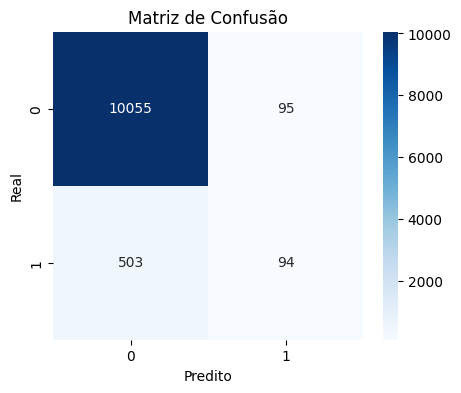

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


df_model = df.copy()

# Colunas irrelevantes para remover
cols_to_drop = [
    'main_activities_job', 'technical_skills_job',
    'prospect_id', 'prospect_name', 'prospect_comment',
    'prospect_status', 'applicant_id', 'technical_knowledge'
]

df_model = df_model.drop(columns=[col for col in cols_to_drop if col in df_model.columns])

# Separar X e y
X = df_model.drop(columns=['is_hired'])
y = df_model['is_hired']

# Colunas categ√≥ricas
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

# Transformadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pr√©-processamento
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Pipeline final
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Treinar modelo
clf.fit(X_train, y_train)

# Avalia√ß√£o
y_pred = clf.predict(X_test)
print("üìä Classification Report:\n", classification_report(y_test, y_pred))

# Matriz de confus√£o
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confus√£o")
plt.show()

### Ajuste de Balanceamento de Classes

Para lidar com o desbalanceamento entre candidatos contratados e n√£o contratados, o modelo foi ajustado com `class_weight='balanced'` no `RandomForestClassifier`. Essa t√©cnica for√ßa o algoritmo a dar mais import√¢ncia √† classe minorit√°ria durante o treinamento, sem a necessidade de alterar os dados (como ocorre em t√©cnicas de oversampling).

#### Objetivo:
Melhorar o **recall da classe 1 (contratado)**, que anteriormente era muito baixo (~16%).

#### Vantagens:
- F√°cil de implementar
- Mant√©m a integridade dos dados
- Evita overfitting comum em oversampling


üìä Classification Report (com balanceamento):
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     10150
           1       0.24      0.28      0.26       597

    accuracy                           0.91     10747
   macro avg       0.60      0.61      0.60     10747
weighted avg       0.92      0.91      0.91     10747



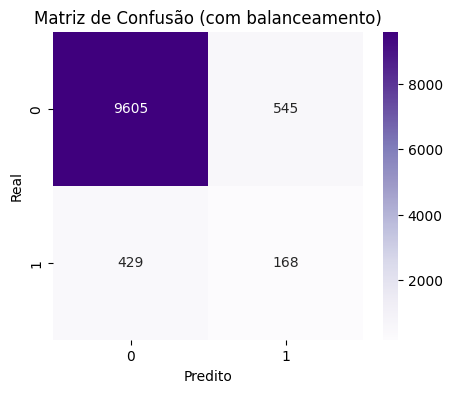

Modelo salvo em random_forest_model.pkl


In [27]:
from sklearn.ensemble import RandomForestClassifier

# Atualizar pipeline com class_weight='balanced'
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# Treinamento e avalia√ß√£o
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# M√©tricas
print("üìä Classification Report (com balanceamento):\n", classification_report(y_test, y_pred))

# Matriz de confus√£o
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confus√£o (com balanceamento)")
plt.show()

# Salvar o modelo treinado
model_path = 'random_forest_model.pkl'
joblib.dump(clf, model_path)
print(f"Modelo salvo em {model_path}")  

### Compara√ß√£o de Desempenho com Balanceamento de Classes

Com o ajuste `class_weight='balanced'`, o modelo passou a reconhecer melhor os candidatos contratados, que eram subrepresentados na base. Abaixo, o novo relat√≥rio de desempenho:




## Conclus√£o:
- O *recall* da classe `Contratado` aumentou de **0.16 para 0.28**, o que significa que o modelo agora reconhece mais candidatos com potencial real.
- Isso √© desej√°vel em cen√°rios de recomenda√ß√£o de talentos, onde **n√£o perder candidatos bons √© mais importante que acertar todos perfeitamente**.

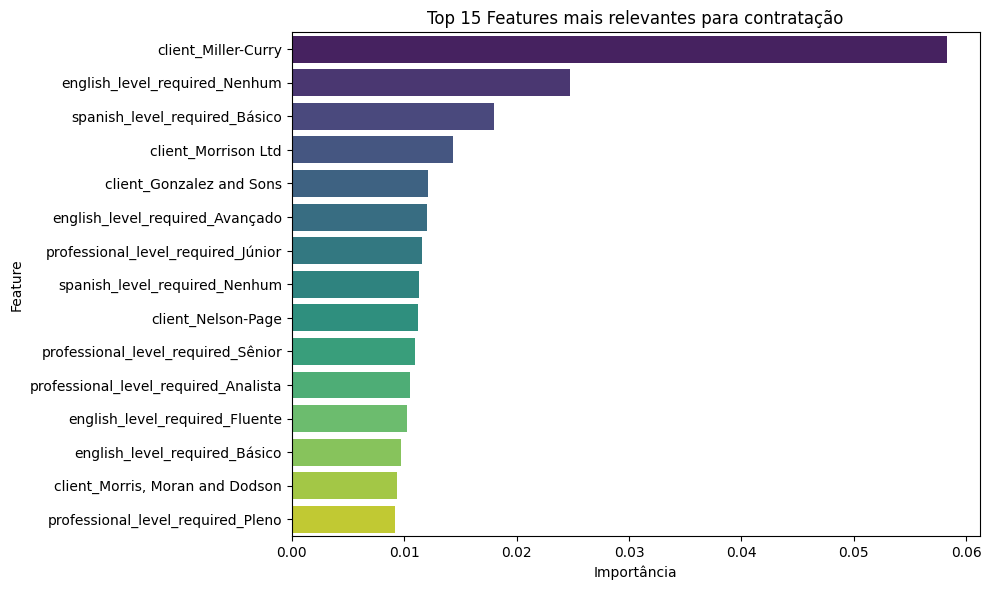

In [28]:
import numpy as np
import pandas as pd

# Extrair o modelo e o pr√©-processador da pipeline
rf_model = clf.named_steps['classifier']
preprocessor = clf.named_steps['preprocessor']

# Obter os nomes das colunas transformadas
# 1. Nomes num√©ricos
numeric_features = num_cols.tolist()

# 2. Nomes categ√≥ricos expandidos via OneHotEncoder
cat_features_encoded = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)

# Juntar todos os nomes
all_feature_names = np.concatenate([numeric_features, cat_features_encoded])

# Obter import√¢ncias
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Visualizar as 15 mais importantes
top_n = 15
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df.head(top_n),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title(f'Top {top_n} Features mais relevantes para contrata√ß√£o')
plt.xlabel('Import√¢ncia')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Principais Fatores para Contrata√ß√£o ##
Com base na import√¢ncia das vari√°veis apresentadas, que refletem os atributos mais relevantes para a contrata√ß√£o, podemos destacar os seguintes padr√µes:

**Necessidade de Idiomas Espec√≠ficos:** A presen√ßa proeminente de english_level_required_Nenhum e spanish_level_required_B√°sico, e em menor grau english_level_required_Avan√ßado e english_level_required_Fluente, sugere que a exig√™ncia de idiomas na vaga √© um fator cr√≠tico. Para vagas onde n√£o √© exigido ingl√™s (Nenhum), ou apenas um b√°sico de espanhol (B√°sico), h√° uma alta relev√¢ncia para a contrata√ß√£o. No entanto, tamb√©m h√° import√¢ncia para n√≠veis mais altos de ingl√™s (Avan√ßado, Fluente), indicando que a adequa√ß√£o ao requisito de idioma da vaga √© fundamental.

**Requisitos de N√≠vel Profissional:** O n√≠vel profissional da vaga, como professional_level_required_J√∫nior, S√™nior, Analista e Pleno, aparece consistentemente entre as caracter√≠sticas mais importantes. Isso indica que o alinhamento entre o n√≠vel de experi√™ncia do candidato e o n√≠vel exigido pela vaga √© um forte preditor de sucesso na contrata√ß√£o.

**Clientes Espec√≠ficos como Fatores de Destaque:** A vari√°vel client_Miller-Curry √© a mais relevante, seguida por client_Morrison Ltd, client_Gonzalez and Sons e client_Nelson-Page. Isso aponta que as particularidades e as necessidades de contrata√ß√£o de clientes espec√≠ficos exercem uma influ√™ncia significativa no resultado da contrata√ß√£o. Pode haver um "fit" cultural ou t√©cnico muito espec√≠fico que a Decision j√° domina para esses clientes.


**Observa√ß√£o de N√≠veis de Idioma Requeridos vs. Habilidades do Candidato:** √â interessante notar que o gr√°fico mostra os requisitos da vaga (e.g., english_level_required_Nenhum) e n√£o diretamente as habilidades do candidato. Isso implica que o ajuste entre o que a vaga pede e o perfil do candidato √© mais importante do que apenas ter um determinado n√≠vel de idioma absoluto. A Decision busca conectar talentos qualificados √†s necessidades espec√≠ficas dos clientes.

Esses insights s√£o cruciais para a Decision, que foca na agilidade e precis√£o no "match" entre candidatos e vagas. Ao entender quais requisitos de vagas e quais clientes est√£o mais associados √† contrata√ß√£o, a empresa pode otimizar a busca por novos talentos e refinar a cria√ß√£o de "personas" para processos seletivos futuros, garantindo que cada decis√£o de contrata√ß√£o seja baseada em dados concretos e an√°lises profunda.

Esses padr√µes sugerem que, para melhorar as chances de contrata√ß√£o, o foco n√£o deve estar apenas em compet√™ncias absolutas dos candidatos, mas em mapear e priorizar requisitos de cada cliente. Dessa forma, √© poss√≠vel estruturar pipelines de talentos mais eficazes e segmentar o recrutamento de forma estrat√©gica.

In [29]:
# Filtrar apenas registros contratados com os 3 campos preenchidos
df_hired_3d = df[
    (df['is_hired'] == 1) &
    (df['professional_level_required'].notna()) &
    (df['english_level_applicant'].notna()) &
    (df['area_of_expertise'].notna()) &
    (df['english_level_applicant'].str.strip() != '') &
    (df['area_of_expertise'].str.strip() != '')
]

# Agrupar e contar as combina√ß√µes
personas_3d = (
    df_hired_3d
    .groupby(['professional_level_required', 'english_level_applicant', 'area_of_expertise'])
    .size()
    .reset_index(name='num_contratados')
    .sort_values(by='num_contratados', ascending=False)
    .head(5)
)

personas_3d

professional_level_required english_level_applicant  \
176                      S√™nior           Intermedi√°rio   
146                      S√™nior                  B√°sico   
136                      S√™nior                Avan√ßado   
126                      S√™nior                Avan√ßado   
10                     Analista                Avan√ßado   

                    area_of_expertise  num_contratados  
176  TI - Desenvolvimento/Programa√ß√£o               25  
146  TI - Desenvolvimento/Programa√ß√£o               19  
136                          TI - SAP               17  
126  TI - Desenvolvimento/Programa√ß√£o               13  
10                           TI - SAP               10

### Personas 3D: Senioridade + N√≠vel de Ingl√™s + √Årea de Atua√ß√£o

Com base nos dados dos candidatos contratados, foram identificadas as 5 combina√ß√µes mais frequentes entre:

- N√≠vel profissional da vaga,
- N√≠vel de ingl√™s do candidato,
- √Årea de expertise profissional.

| N√≠vel Profissional | N√≠vel de Ingl√™s | √Årea de Atua√ß√£o                   | N¬∫ de Contratados |
|--------------------|------------------|-----------------------------------|-------------------|
| S√™nior             | Intermedi√°rio    | TI - Desenvolvimento/Programa√ß√£o | 25                |
| S√™nior             | B√°sico           | TI - Desenvolvimento/Programa√ß√£o | 19                |
| S√™nior             | Avan√ßado         | TI - SAP                          | 17                |
| S√™nior             | Avan√ßado         | TI - Desenvolvimento/Programa√ß√£o | 13                |
| Analista           | Avan√ßado         | TI - SAP                          | 10                |

#### Interpreta√ß√£o Estrat√©gica:

- A **√°rea de TI - Desenvolvimento/Programa√ß√£o** aparece com for√ßa, principalmente entre profissionais **S√™nior**, mesmo com ingl√™s **B√°sico ou Intermedi√°rio**, sugerindo que a flu√™ncia total nem sempre √© uma exig√™ncia em contextos t√©cnicos locais.
- A combina√ß√£o de **S√™nior + Avan√ßado + TI - SAP** indica um perfil altamente especializado e valorizado, refletindo o peso do conhecimento em SAP no mercado.
- A presen√ßa de perfis **Analista com ingl√™s avan√ßado em SAP** aponta para uma **segunda camada de especializa√ß√£o**, onde o ingl√™s √© diferencial mesmo em posi√ß√µes t√©cnicas intermedi√°rias.

#### Aplica√ß√µes pr√°ticas:

- **Priorizar candidatos** com perfis semelhantes durante os processos seletivos, especialmente em vagas com maior urg√™ncia ou exig√™ncia t√©cnica.
- **Customizar comunica√ß√£o de recrutamento** com base nas personas identificadas (ex: campanhas espec√≠ficas para Devs S√™nior com ingl√™s b√°sico/intermedi√°rio).
- **Criar programas de capacita√ß√£o lingu√≠stica** para perfis t√©cnicos promissores que ainda n√£o possuem ingl√™s avan√ßado ‚Äî com base nos perfis que j√° foram contratados sem essa flu√™ncia.

‚û°Ô∏è Essas personas enriquecem o entendimento do que √© um "perfil ideal" para diferentes tipos de vaga, permitindo √† Decision atuar de forma mais estrat√©gica na composi√ß√£o de seus pipelines de talento.


### An√°lise de Atributos dos Candidatos por Cluster

Com base nos dados clusterizados, foi poss√≠vel identificar os perfis com maior taxa de contrata√ß√£o. Abaixo est√£o os principais resultados:

| Cluster | N√≠vel Profissional | Ingl√™s        | √Årea de Atua√ß√£o                   | Taxa de Contrata√ß√£o |
|---------|---------------------|----------------|-----------------------------------|----------------------|
| 2       | J√∫nior              | B√°sico         | TI - SAP                          | 22,5%                |
| 0       | J√∫nior              | B√°sico         | TI - Desenvolvimento/Programa√ß√£o | 15,8%                |
| 3       | J√∫nior              | (vazio)        | TI - Desenvolvimento/Programa√ß√£o | 14,4%                |
| 4       | S√™nior              | Intermedi√°rio  | TI - SAP                          | 14,3%                |
| 1       | J√∫nior              | (vazio)        | TI - Suporte                      | 12,8%                |

#### Conclus√£o:
- O perfil **J√∫nior com conhecimento b√°sico de ingl√™s e atua√ß√£o em SAP** lidera a taxa de sucesso, mostrando um segmento promissor para recrutamento.
- O ingl√™s intermedi√°rio aparece em perfis seniores com boa taxa de convers√£o, refor√ßando seu valor em posi√ß√µes mais t√©cnicas.
- Perfis com aus√™ncia de dados de idioma ainda apresentam contrata√ß√£o, mas podem beneficiar-se de melhor preenchimento de dados para futura an√°lise.
